# RSNA Pnumonia Exploratory Data Analysis(EDA)
Resource:
1. [Data](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data)
2. [RSNA Pneumonia Detection EDA](https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda)
3. [Exploratory Data Analysis](https://www.kaggle.com/peterchang77/exploratory-data-analysis)
4. [Intro EDA with DICOM Metadata](https://www.kaggle.com/jtlowery/intro-eda-with-dicom-metadata)

In [12]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
import os
import pydicom
import glob
%matplotlib inline 

# Data preparation
## load data

In [2]:
PATH="./rsna-pneumonia-detection-challenge"
print('Files:',os.listdir(PATH))

Files: ['stage_2_sample_submission.csv', 'stage_2_train_images', 'GCP Credits Request Link - RSNA.txt', 'stage_2_detailed_class_info.csv', 'stage_2_train_labels.csv', 'stage_2_test_images']


In [3]:
# load data
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')
sample_submission_df = pd.read_csv(PATH+'/stage_2_sample_submission.csv')

## data description
1. In class detailed info dataset are given the detailed information about the type of positive or negative class associated with a certain patient.
2. In train labels dataset are given the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia.
3. What should I expect the data format to be?
    - The training data is provided as a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x-min y-min width height
    - There is also a binary target column, Target, indicating pneumonia or non-pneumonia.
    - There may be multiple rows per patientId.

## data format

In [4]:
# image class information
print(f"row: {class_info_df.shape[0]}, column: {class_info_df.shape[1]}")
class_info_df.head()

row: 30227, column: 2


patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [141]:
class_info_dropdu_df=class_info_df.drop_duplicates('patientId', keep='first')
class_info_dropdu_df.shape

(26684, 2)

In [5]:
# image bounding box information
print(f"row: {train_labels_df.shape[0]}, column: {train_labels_df.shape[1]}")
train_labels_df.head()

row: 30227, column: 6


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [6]:
# predict format
print(f"row: {sample_submission_df.shape[0]}, column: {sample_submission_df.shape[1]}")
sample_submission_df.head()

row: 3000, column: 2


patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100

## merge dataframe

In [7]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [9]:
print(f"row: {train_class_df.shape[0]}, column: {train_class_df.shape[1]}, patient numbers:{len(train_class_df.patientId.unique())}")
train_class_df.head()

row: 37629, column: 7, patient numbers:26684


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

## Check missing data
It has been done by [RSNA Pneumonia Detection EDA](https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda), so I skip this step.

## Meta data preparation

In [13]:
# get lists of all train/test dicom filepaths
train_dcm_fps = glob.glob(PATH+'/stage_2_train_images/*.dcm')
#test_dcm_fps = glob.glob(PATH+'/stage_2_test_images/*.dcm')

# read each file into a list (using stop_before_pixels to avoid reading the image for speed and memory savings)
train_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in train_dcm_fps]
#test_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in test_dcm_fps]

In [40]:
def parse_dcm_metadata(dcm):
    unpacked_data = {}
    group_elem_to_keywords = {}
    # iterating here to force conversion from lazy RawDataElement to DataElement
    for d in dcm:
        pass
    # keys are pydicom.tag.BaseTag, values are pydicom.dataelem.DataElement
    for tag, elem in dcm.items():
        tag_group = tag.group
        tag_elem = tag.elem
        keyword = elem.keyword
        group_elem_to_keywords[(tag_group, tag_elem)] = keyword
        value = elem.value
        unpacked_data[keyword] = value
    return unpacked_data, group_elem_to_keywords

train_meta_dicts, tag_to_keyword_train = zip(*[parse_dcm_metadata(x) for x in train_dcms])
#test_meta_dicts, tag_to_keyword_test = zip(*[parse_dcm_metadata(x) for x in test_dcms])

In [42]:
# join all the dicts
unified_tag_to_key_train = {k:v for dict_ in tag_to_keyword_train for k,v in dict_.items()}
#unified_tag_to_key_test = {k:v for dict_ in tag_to_keyword_test for k,v in dict_.items()}


In [77]:
train_df = pd.DataFrame.from_records(data=train_meta_dicts)
'''
test_df = pd.DataFrame.from_records(data=test_meta_dicts)
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
df = pd.concat([train_df, test_df])
'''

"\ntest_df = pd.DataFrame.from_records(data=test_meta_dicts)\ntrain_df['dataset'] = 'train'\ntest_df['dataset'] = 'test'\ndf = pd.concat([train_df, test_df])\n"

In [52]:
train_df.head()

SpecificCharacterSet                SOPClassUID  \
0           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
1           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
2           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
3           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
4           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   

                                      SOPInstanceUID StudyDate  StudyTime  \
0  1.2.276.0.7230010.3.1.4.8323329.10083.15178743...  19010101  000000.00   
1  1.2.276.0.7230010.3.1.4.8323329.3000.151787429...  19010101  000000.00   
2  1.2.276.0.7230010.3.1.4.8323329.16999.15178744...  19010101  000000.00   
3  1.2.276.0.7230010.3.1.4.8323329.21147.15178744...  19010101  000000.00   
4  1.2.276.0.7230010.3.1.4.8323329.3537.151787430...  19010101  000000.00   

  AccessionNumber Modality ConversionType ReferringPhysicianName  \
0                       CR            WSD                          
1                       CR            WSD                          
2                       CR            WSD                          
3                       CR            WSD                          
4                       CR            WSD                          

  SeriesDescription  ... PhotometricInterpretation  Rows Columns  \
0          view: AP  ...               MONOCHROME2  1024    1024   
1          view: PA  ...               MONOCHROME2  1024    1024   
2          view: AP  ...               MONOCHROME2  1024    1024   
3          view: AP  ...               MONOCHROME2  1024    1024   
4          view: AP  ...               MONOCHROME2  1024    1024   

                                 PixelSpacing BitsAllocated BitsStored  \
0                              [0.139, 0.139]             8          8   
1  [0.14300000000000002, 0.14300000000000002]             8          8   
2                              [0.168, 0.168]             8          8   
3                              [0.168, 0.168]             8          8   
4                              [0.168, 0.168]             8          8   

  HighBit PixelRepresentation LossyImageCompression  \
0       7                   0                    01   
1       7                   0                    01   
2       7                   0                    01   
3       7                   0                    01   
4       7                   0                    01   

  LossyImageCompressionMethod  
0                 ISO_10918_1  
1                 ISO_10918_1  
2                 ISO_10918_1  
3                 ISO_10918_1  
4                 ISO_10918_1  

[5 rows x 34 columns]

In [78]:
# separating PixelSpacing list to single values
train_df['PixelSpacing_x'] = train_df['PixelSpacing'].apply(lambda x: x[0])
train_df['PixelSpacing_y'] = train_df['PixelSpacing'].apply(lambda x: x[1])
train_df = train_df.drop(['PixelSpacing'], axis='columns')

# x and y are always the same
assert sum(train_df['PixelSpacing_x'] != train_df['PixelSpacing_y']) == 0

In [79]:
# ReferringPhysicianName appears to just be empty strings
assert sum(train_df['ReferringPhysicianName'] != '') == 0

# SeriesDescription appears to be 'view: {}'.format(ViewPosition)
set(train_df['SeriesDescription'].unique())

{'view: AP', 'view: PA'}

In [80]:
nunique_all=train_df.aggregate('nunique')
nunique_all

SpecificCharacterSet               1
SOPClassUID                        1
SOPInstanceUID                 26684
StudyDate                          1
StudyTime                          1
AccessionNumber                    1
Modality                           1
ConversionType                     1
ReferringPhysicianName             1
SeriesDescription                  2
PatientName                    26684
PatientID                      26684
PatientBirthDate                   1
PatientSex                         2
PatientAge                        97
BodyPartExamined                   1
ViewPosition                       2
StudyInstanceUID               26684
SeriesInstanceUID              26684
StudyID                            1
SeriesNumber                       1
InstanceNumber                     1
PatientOrientation                 1
SamplesPerPixel                    1
PhotometricInterpretation          1
Rows                               1
Columns                            1
B

In [81]:
# drop constant cols and other two from above
train_df = train_df.drop(nunique_all[nunique_all == 1].index.tolist() + ['ReferringPhysicianName', 'SeriesDescription'], axis='columns')

# now that we have a clean metadata dataframe we can merge back to our initial tabular data with target and class info
train_df = train_df.merge(train_class_df, how='left', left_on='PatientID', right_on='patientId')

train_df['PatientAge'] = train_df['PatientAge'].astype(int)

In [82]:
print(train_df.shape)
train_df.head()

(37629, 17)


SOPInstanceUID  \
0  1.2.276.0.7230010.3.1.4.8323329.10083.15178743...   
1  1.2.276.0.7230010.3.1.4.8323329.3000.151787429...   
2  1.2.276.0.7230010.3.1.4.8323329.16999.15178744...   
3  1.2.276.0.7230010.3.1.4.8323329.21147.15178744...   
4  1.2.276.0.7230010.3.1.4.8323329.21147.15178744...   

                            PatientName                             PatientID  \
0  1fa9f43b-3f5f-4c16-8731-c88d71ee6e0b  1fa9f43b-3f5f-4c16-8731-c88d71ee6e0b   
1  d4b8eb6a-ebf1-4752-b5a6-4737c5890061  d4b8eb6a-ebf1-4752-b5a6-4737c5890061   
2  7437e61c-7aba-478a-9398-0eed93ba42f5  7437e61c-7aba-478a-9398-0eed93ba42f5   
3  b165b941-4ec6-4f1b-9f03-2e908de24266  b165b941-4ec6-4f1b-9f03-2e908de24266   
4  b165b941-4ec6-4f1b-9f03-2e908de24266  b165b941-4ec6-4f1b-9f03-2e908de24266   

  PatientSex  PatientAge ViewPosition  \
0          F          74           AP   
1          F          52           PA   
2          M          53           AP   
3          M          69           AP   
4          M          69           AP   

                                    StudyInstanceUID  \
0  1.2.276.0.7230010.3.1.2.8323329.10083.15178743...   
1  1.2.276.0.7230010.3.1.2.8323329.3000.151787429...   
2  1.2.276.0.7230010.3.1.2.8323329.16999.15178744...   
3  1.2.276.0.7230010.3.1.2.8323329.21147.15178744...   
4  1.2.276.0.7230010.3.1.2.8323329.21147.15178744...   

                                   SeriesInstanceUID  PixelSpacing_x  \
0  1.2.276.0.7230010.3.1.3.8323329.10083.15178743...           0.139   
1  1.2.276.0.7230010.3.1.3.8323329.3000.151787429...           0.143   
2  1.2.276.0.7230010.3.1.3.8323329.16999.15178744...           0.168   
3  1.2.276.0.7230010.3.1.3.8323329.21147.15178744...           0.168   
4  1.2.276.0.7230010.3.1.3.8323329.21147.15178744...           0.168   

   PixelSpacing_y                             patientId      x      y  width  \
0           0.139  1fa9f43b-3f5f-4c16-8731-c88d71ee6e0b    NaN    NaN    NaN   
1           0.143  d4b8eb6a-ebf1-4752-b5a6-4737c5890061    NaN    NaN    NaN   
2           0.168  7437e61c-7aba-478a-9398-0eed93ba42f5    NaN    NaN    NaN   
3           0.168  b165b941-4ec6-4f1b-9f03-2e908de24266  354.0  375.0  164.0   
4           0.168  b165b941-4ec6-4f1b-9f03-2e908de24266  354.0  375.0  164.0   

   height  Target                         class  
0     NaN       0  No Lung Opacity / Not Normal  
1     NaN       0                        Normal  
2     NaN       0                        Normal  
3   293.0       1                  Lung Opacity  
4   293.0       1                  Lung Opacity

In [66]:
# df now has multiple rows for some patients (those with multiple bounding boxes in label_w_class)
# so creating one with no duplicates for patients
train_df_deduped = train_df.drop_duplicates('PatientID', keep='first')

# Exploratory data
## Exploratory meta data

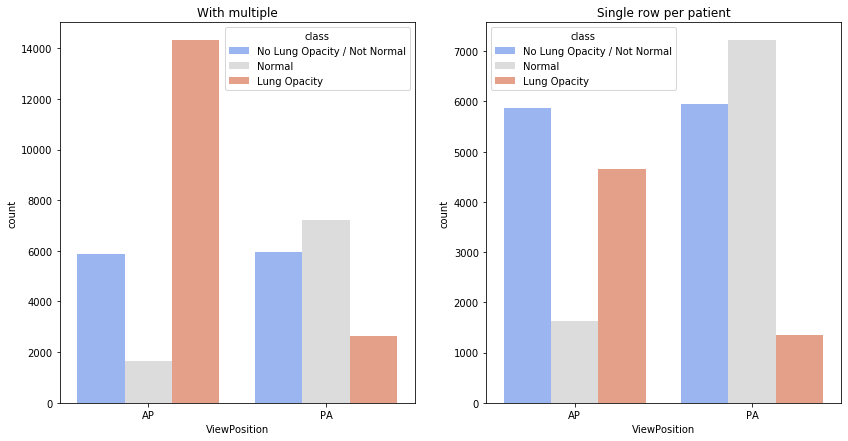

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='class', data=train_df, ax=axes[0], palette="coolwarm")
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='class', data=train_df_deduped, ax=axes[1], palette="coolwarm")
_ = p.set_title('Single row per patient')

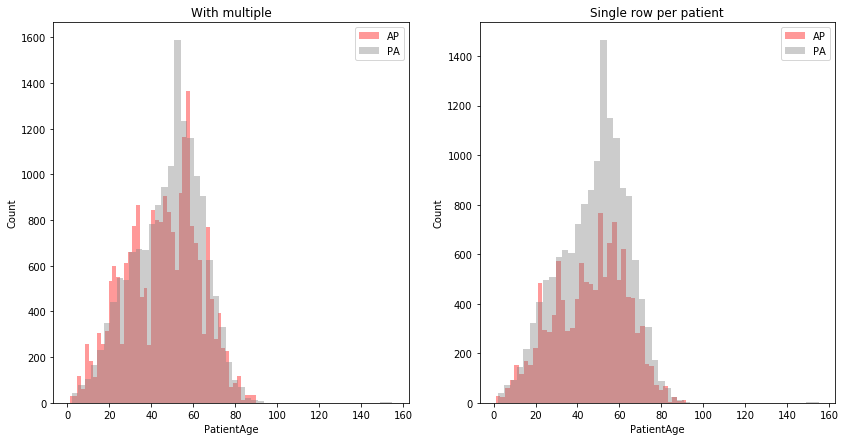

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(train_df[train_df['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[0])
p = sns.distplot(train_df[train_df['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('With multiple')

p = sns.distplot(train_df_deduped[train_df_deduped['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[1])
p = sns.distplot(train_df_deduped[train_df_deduped['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Single row per patient')

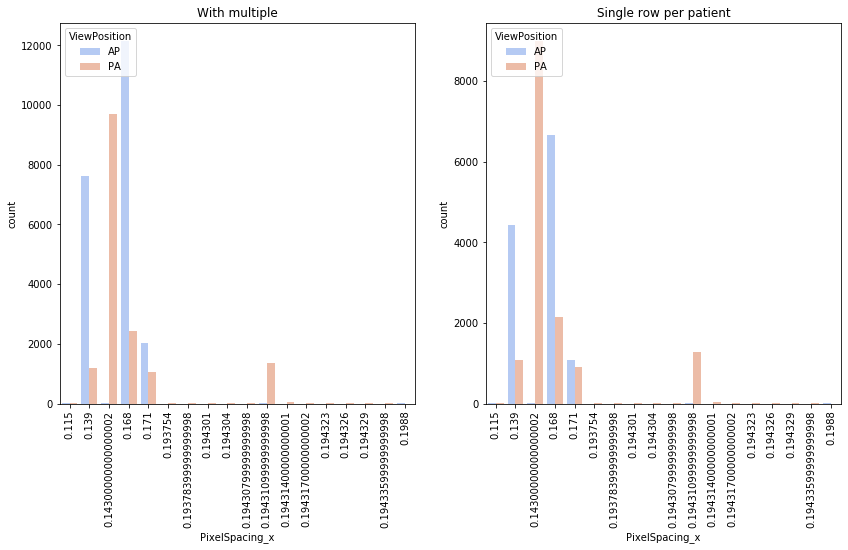

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(train_df['PixelSpacing_x'], hue='ViewPosition', data=train_df, ax=axes[0], palette="coolwarm")
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')

p = sns.countplot(train_df_deduped['PixelSpacing_x'], hue='ViewPosition', data=train_df_deduped, ax=axes[1], palette="coolwarm")
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')

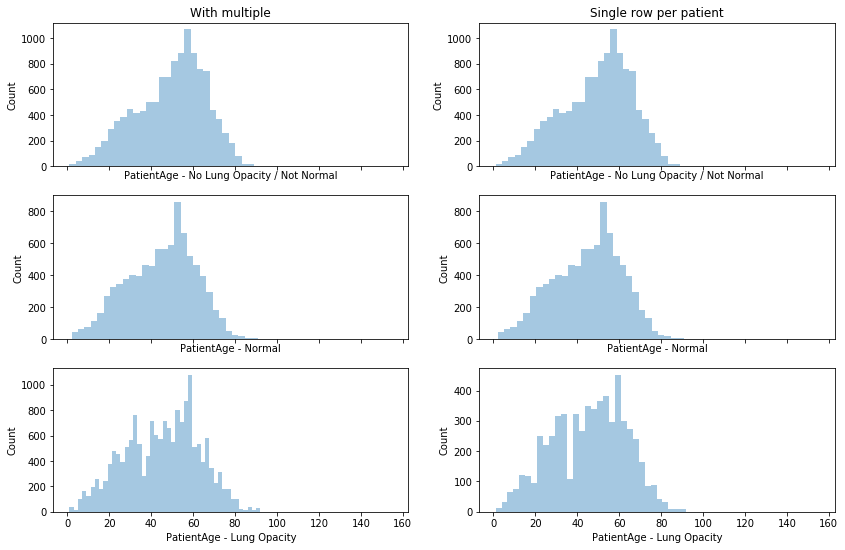

In [93]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)
for i, _class in enumerate(train_df['class'].dropna().unique()):
    p = sns.distplot(train_df[train_df['class']==_class]['PatientAge'], hist=True, kde=False, ax=axes[i, 0])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('With multiple')
    
    p = sns.distplot(train_df_deduped[train_df_deduped['class']==_class]['PatientAge'], hist=True, kde=False, ax=axes[i, 1])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Single row per patient')

## Exploratory tabular data

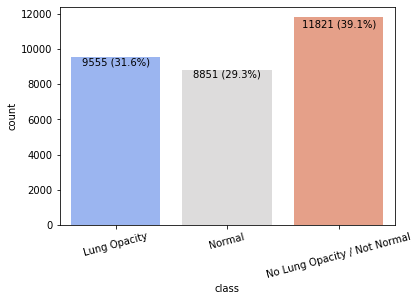

In [139]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order =['Lung Opacity','Normal','No Lung Opacity / Not Normal'], palette='coolwarm')
#sns.countplot(class_info_df['class'],order =class_info_df['class'].value_counts().index,palette='coolwarm')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height-1/20*height,
            '{:1.0f} '.format(height) +'({:1.1f}%)'.format(100*height/total),
            ha="center") 
plt.xticks(rotation=15)
plt.show()

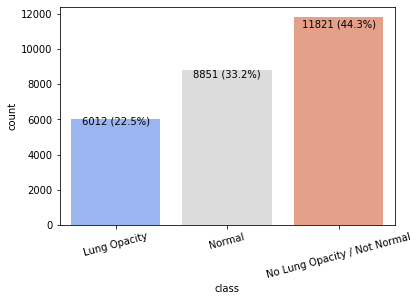

In [142]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_dropdu_df))
sns.countplot(class_info_dropdu_df['class'],order =['Lung Opacity','Normal','No Lung Opacity / Not Normal'], palette='coolwarm')
#sns.countplot(class_info_df['class'],order =class_info_df['class'].value_counts().index,palette='coolwarm')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height-1/20*height,
            '{:1.0f} '.format(height) +'({:1.1f}%)'.format(100*height/total),
            ha="center") 
plt.xticks(rotation=15)
plt.show()


In [80]:
train_class_df.groupby('class')['Target'].value_counts()

class                         Target
Lung Opacity                  1         16957
No Lung Opacity / Not Normal  0         11821
Normal                        0          8851
Name: Target, dtype: int64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


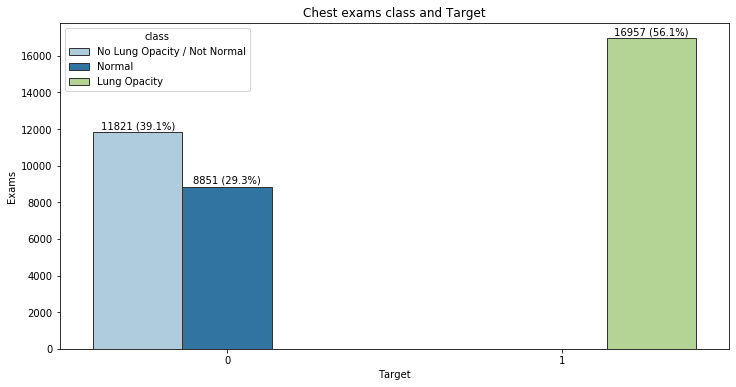

In [128]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette="Paired", edgecolor=".2")
plt.title("Chest exams class and Target")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+200,
            '{:1.0f} '.format(height) +'({:1.1f}%)'.format(100*height/total),
            ha="center") 
plt.show()

In [95]:
train_PATH=PATH+'/stage_2_train_images/'
train_PATH

'./rsna-pneumonia-detection-challenge/stage_2_train_images/'

In [96]:
len(os.listdir(train_PATH))

26684

## Display image data
Exploratory image data has been done on mask-rcnn-pneumonua-data.ipynb

In [148]:
dcm_file = train_PATH+'3ebe379f-90fc-44a7-9602-71c5abfdd50a.dcm'
dcm_data = pydicom.read_file(dcm_file)
im = dcm_data.pixel_array

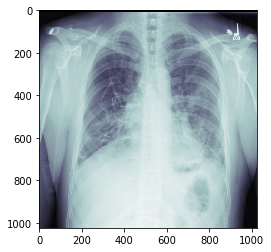

In [150]:
plt.imshow(im, cmap='bone')

In [112]:
# Forked from `https://www.kaggle.com/peterchang77/exploratory-data-analysis`
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(train_labels_df)

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        rgb = [255, 251, 204] # Just use yellow
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=5)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=5):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

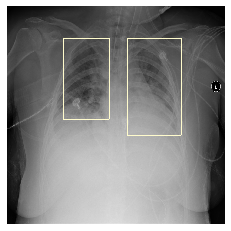

In [111]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

In [108]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        view = data_row_img_data.ViewPosition
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} view: {}\n Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, view, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

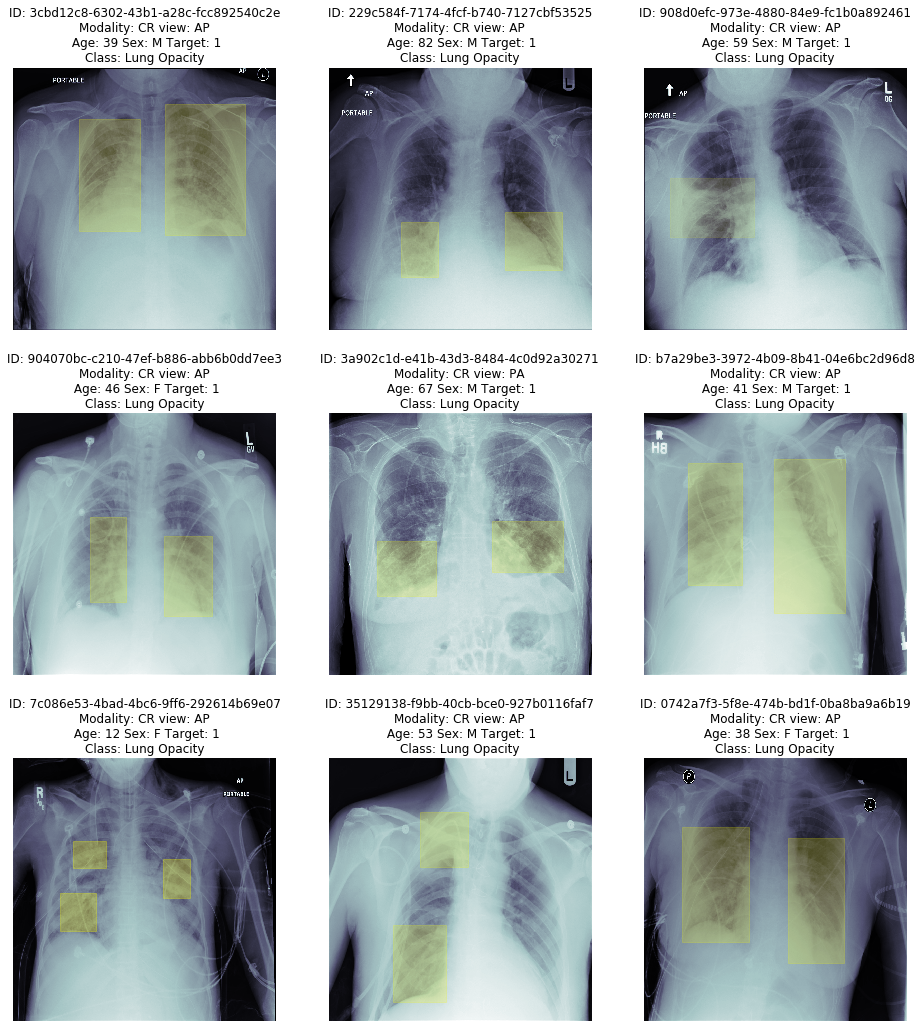

In [117]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

In [144]:
import matplotlib.patches as patches
def show_dicom_images_with_boxes_v2(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        view = data_row_img_data.ViewPosition
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        im = data_row_img_data.pixel_array
        ax[i//3, i%3].imshow(im, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} view: {}\n Age: {} Sex: {} \nClass: {}'.format(
                data_row['patientId'],modality, view, age, sex, data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        edgecolor="yellow",facecolor='none'))   
    plt.show()


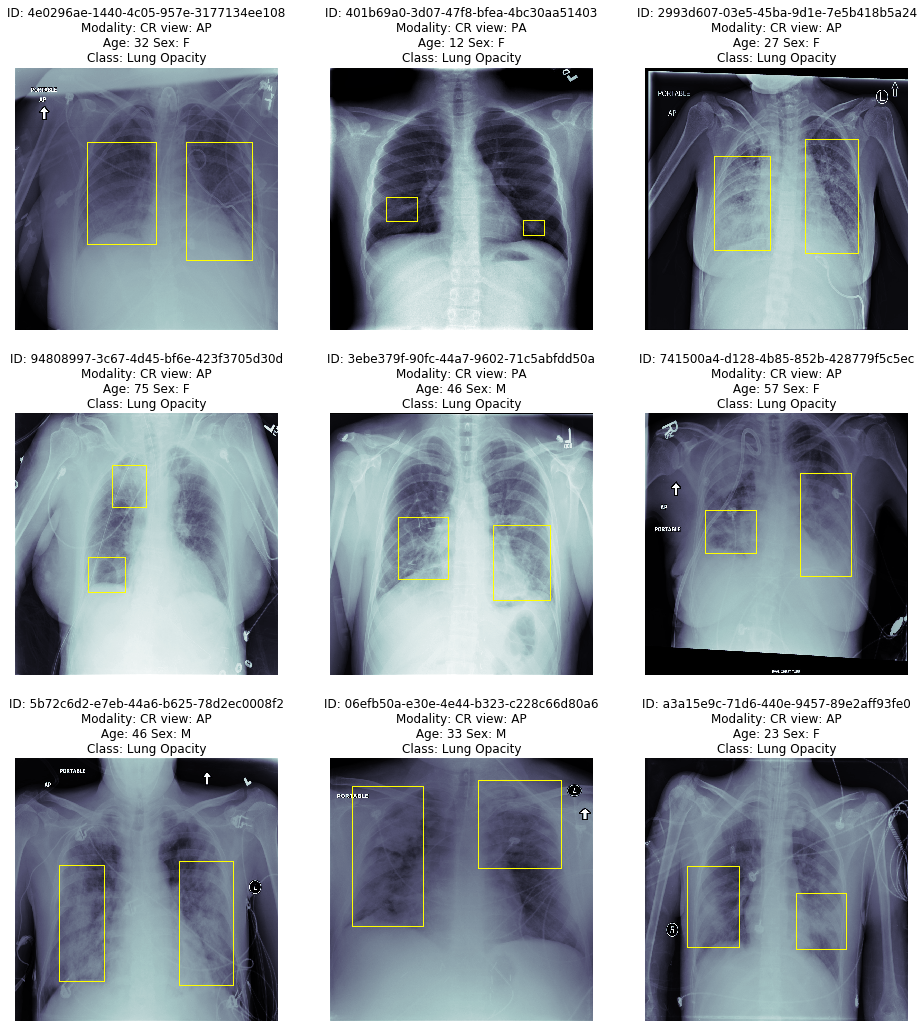

In [145]:
show_dicom_images_with_boxes_v2(train_class_df[train_class_df['Target']==1].sample(9))

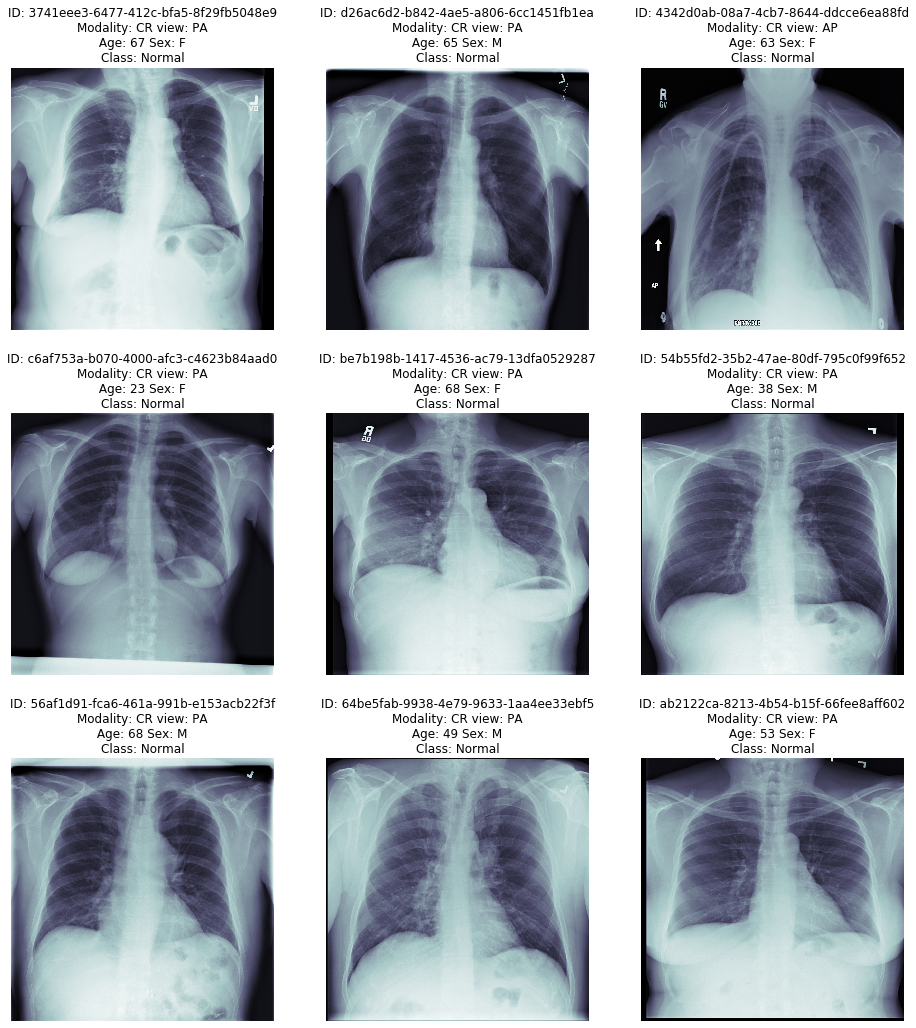

In [146]:
show_dicom_images_with_boxes_v2(train_class_df[train_class_df['class']=='Normal'].sample(9))

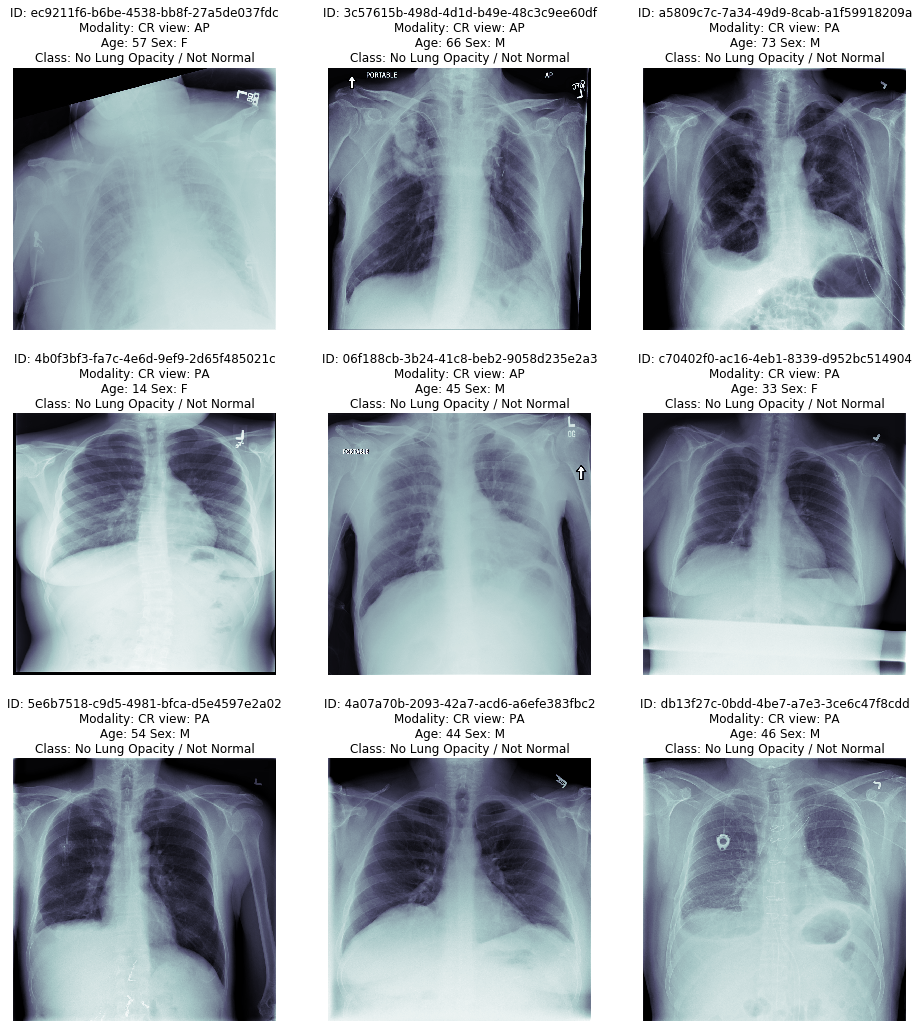

In [147]:
show_dicom_images_with_boxes_v2(train_class_df[train_class_df['class']=='No Lung Opacity / Not Normal'].sample(9))